# Example Usage

## Step 1: Load Data, Get Alignments

First we need to load the data and optimise the alignment of camera and object positions/orientations etc optimised from images.

In [1]:
import alignment
import numpy as np
from copy import deepcopy
import pickle
import trajectory
import matplotlib.pyplot as plt
%matplotlib inline

image_filenames = {}
for camidx in [1,2,3,4]:
    image_filenames['cam%d' % camidx] = alignment.grab_photos_in_timerange('/home/mike/Documents/Research/bee/photos2021/20thJuly/system00%d' % camidx,'13:58:00','13:58:59')
    
a = alignment.Align('/home/mike/Documents/Research/bee/photos2021/20thJuly/config000000.json',image_filenames)    

a.optimise_positions()
a.found = {}
a.load_photos_for_alignment(True)
a.find_markers()
fov, ret = a.estimate_fov()  
#a.fov = 0.88 #2*np.arctan(np.sqrt(14.11**2 / (1+0.75**2)) / (2*8)) 
#a.fov = np.deg2rad(66)
#computed from sensor=1/1.8"=14.11mm, and lens = 8mm focal length.
#a.fov = 2*np.arctan(np.sqrt(14.11**2 / (1+0.75**2)) / (2*8))
#print("Estimate of the FOV: %d degrees" % np.rad2deg(fov))
a.build_newitems()

#get the camera and object positions/orientations etc optimised from images.
np.set_printoptions(precision=1,suppress=True)
optx = a.generate_alignment(300)

Trying to load from cache (found_cache_1274829278731846147986828743320540924804757925953.pkl)
Trying to load from cache (found_cache_405618279165676041551605623265213909585445455494.pkl)
Trying to load from cache (found_cache_304478011998845253045659555878010926215611062409.pkl)
Trying to load from cache (found_cache_967346039333954414453007365603989740662921907388.pkl)
Trying to load from cache (camera_alignment_cache_621090400755232587263163487856068145456285676271.pkl)
Worst position 5 pixels away.


# Step 2: Check the alignments

The best way of checking the alignments is to draw them:

/home/mike/Documents/Research/beelabel/labelling/alignment.py:644: RuntimeWarning: invalid value encountered in true_divide
  res = np.array([1024+1024*(-pvec[:,1]/pvec[:,0])/self.hfovw,(1024+1024*(pvec[:,2]/pvec[:,0]/self.vfovw))*0.75]).T
/home/mike/Documents/Research/beelabel/labelling/alignment.py:644: RuntimeWarning: invalid value encountered in true_divide
  res = np.array([1024+1024*(-pvec[:,1]/pvec[:,0])/self.hfovw,(1024+1024*(pvec[:,2]/pvec[:,0]/self.vfovw))*0.75]).T
/home/mike/Documents/Research/beelabel/labelling/alignment.py:644: RuntimeWarning: invalid value encountered in true_divide
  res = np.array([1024+1024*(-pvec[:,1]/pvec[:,0])/self.hfovw,(1024+1024*(pvec[:,2]/pvec[:,0]/self.vfovw))*0.75]).T
/home/mike/Documents/Research/beelabel/labelling/alignment.py:644: RuntimeWarning: invalid value encountered in true_divide
  res = np.array([1024+1024*(-pvec[:,1]/pvec[:,0])/self.hfovw,(1024+1024*(pvec[:,2]/pvec[:,0]/self.vfovw))*0.75]).T


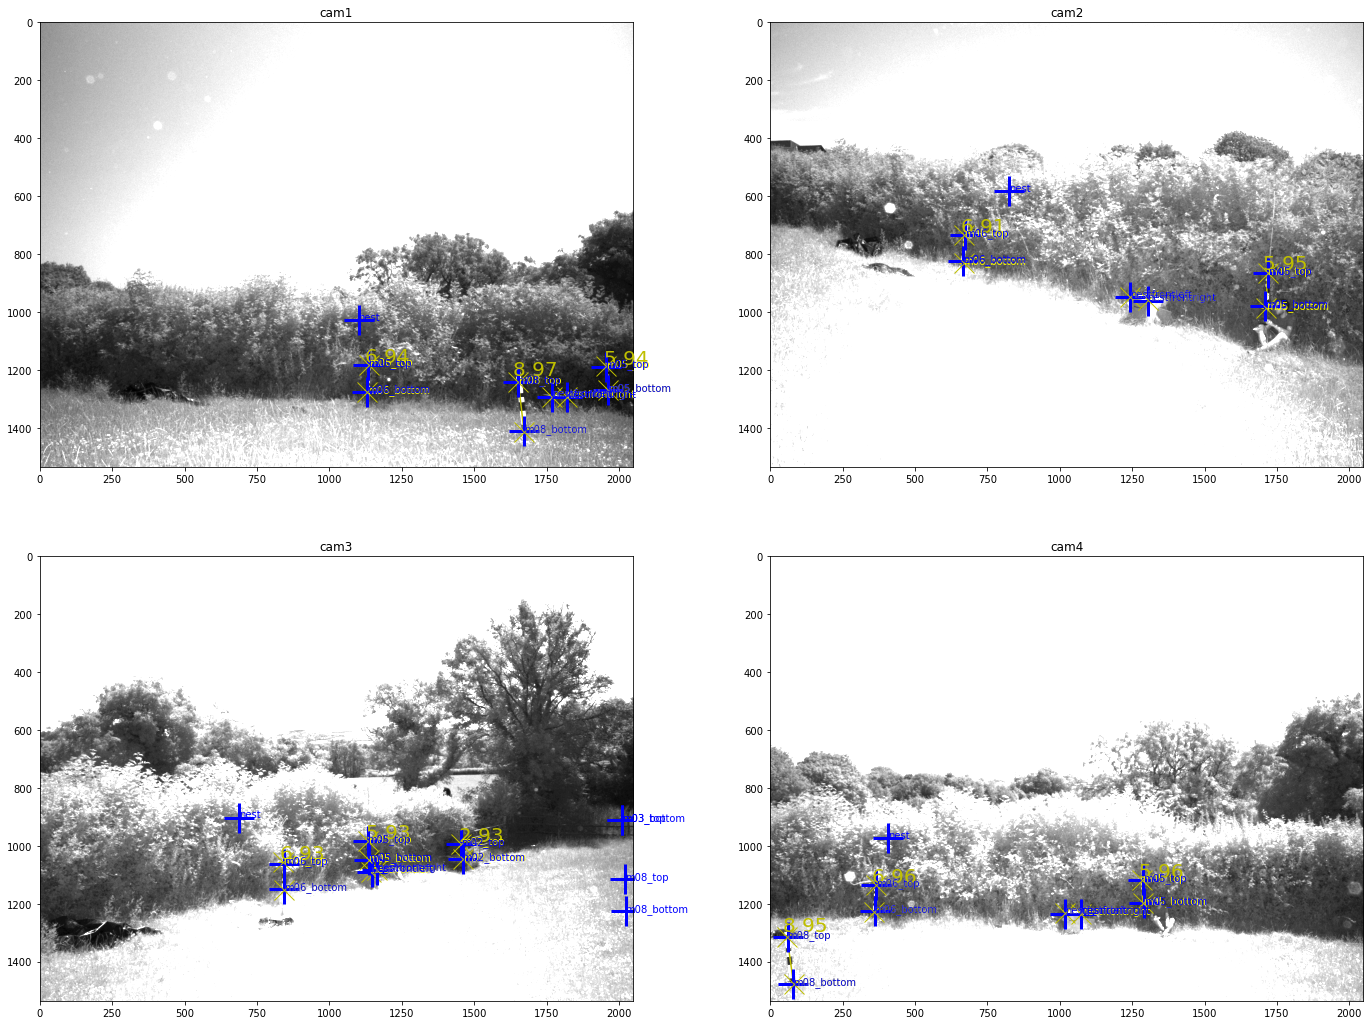

In [2]:
plt.figure(figsize=[24,18])
for i,cam in enumerate(a.cam_photos):
    plt.subplot(2,2,i+1)
    a.draw_found(cam,15,draw_3d_location=True)
    plt.title(cam)

# Step 3: Find the dots in the images

We next need to find the actual dot of the bee in the image. We ignore some patches of the images.

In [5]:
coords = {}
a.compute_retrodectect_coords()
a.process_coords()    
a.build_ignore_patches(nest_item = 'nestfrontright');

Trying to load from cache (coords_1160675470495261200672105812889632141012524772593.pkl) for camera cam1
Trying to load from cache (coords_221128613001237563729749930352050786304326805135.pkl) for camera cam2
Trying to load from cache (coords_1300405415367544120579369131125230578155580781656.pkl) for camera cam3
Trying to load from cache (coords_154058751581584476673758170896807666694747600551.pkl) for camera cam4


{'cam1': [[1536, 1014],
  [512, 957],
  [1220, 1189],
  [1208, 1105],
  [1331, 606],
  [1332, 277]],
 'cam2': [[1675, 545],
  [702, 454],
  [524, 510],
  [1144, 582],
  [614, 249],
  [522, 507]],
 'cam4': [],
 'cam3': [[83, 840]]}

There is a bit of manual intervention - there was a stationary bee in the hedge that I wanted to exclude, so I found its location in the images & removed it.

In [6]:
observations, obstimes = a.build_observations()

# Step 4: Run particle smoothing to estimate trajectory

In [7]:
#get smoothed trajectories (strajs)
pf, strajs = trajectory.run_particle_smoothing(obstimes,a.newitems['nestfrontleft']['coords'],observations,N=20,Nback=20)

# Step 5: Output

In [9]:
trajectory.draw_3d_path(strajs,draw_uncertainty=True)

/home/mike/anaconda3/lib/python3.8/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


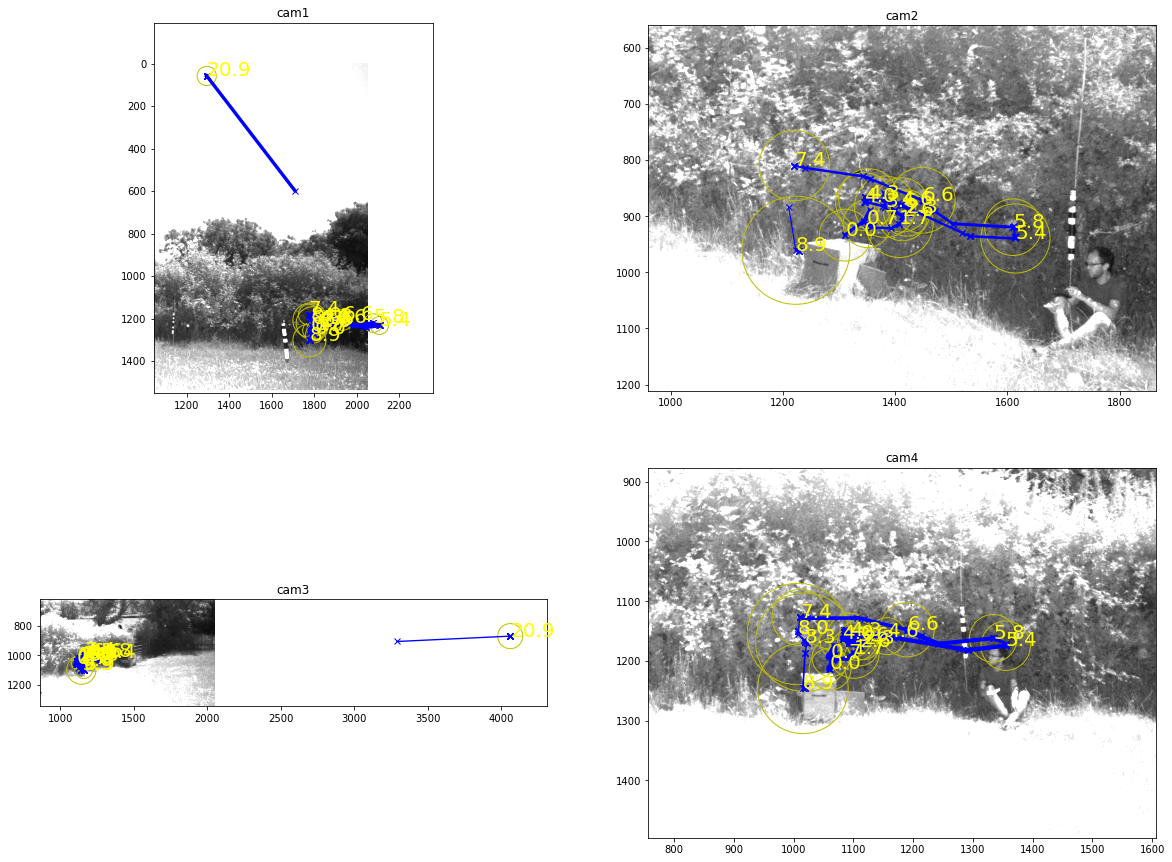

In [10]:
plt.figure(figsize=[20,15])
for i,cam in enumerate(a.cam_photos):
    plt.subplot(2,2,i+1)
    a.draw_path_on_photos(obstimes,strajs,cam)
    plt.title(cam)

(0.0, 5.0)

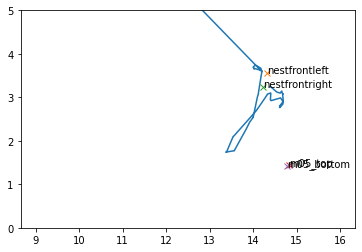

In [11]:
meanstd = np.mean(np.std(strajs,1),1)
meanpath = np.mean(strajs,1)
plt.plot(meanpath[meanstd<0.6,0],meanpath[meanstd<0.6,1])
for it_name in a.newitems:
    it = a.newitems[it_name]
    x,y = it['coords'][0],it['coords'][1]
    if (x<10) or (x>15) or (y<0) or (y>5): continue
    plt.plot(x,y,'x')
    plt.text(x,y,it_name)
plt.axis('equal')
plt.xlim([10,15])
plt.ylim([0,5])